<a href="https://colab.research.google.com/github/myozaw5288/git/blob/master/%D0%94%D0%97_2(%D0%9F%D0%A0%D0%98%D0%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [2]:
foldernames = ['MOURNING DOVE', 'BROWN NOODY', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'WHITE TAILED TROPIC', 'OSPREY', 'HOUSE FINCH', 'AMERICAN COOT', 'GOLDEN PIPIT', 'PUFFIN']
categories = []
files = []
i = 0
flag=0

In [3]:
len(foldernames)

10

In [4]:
for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/drive/MyDrive/img_data/train/" + folder);
    for file in filenames:
        #files.append("../input/100-bird-species/test/" + folder + "/" + file)
        files.append("/content/drive/MyDrive/img_data/train/" + folder + "/" + file)
        #categories.append(k)
        categories.append(k)
     

df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [5]:
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(70):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,/content/drive/MyDrive/img_data/train/MOURNING...,0
1,/content/drive/MyDrive/img_data/train/MOURNING...,0
2,/content/drive/MyDrive/img_data/train/MOURNING...,0
3,/content/drive/MyDrive/img_data/train/MOURNING...,0
4,/content/drive/MyDrive/img_data/train/MOURNING...,0
...,...,...
1452,/content/drive/MyDrive/img_data/train/PUFFIN/0...,9
1453,/content/drive/MyDrive/img_data/train/PUFFIN/0...,9
1454,/content/drive/MyDrive/img_data/train/PUFFIN/1...,9
1455,/content/drive/MyDrive/img_data/train/PUFFIN/0...,9


In [6]:
y = train_df['category']
x = train_df['filename']
x, y = shuffle(x, y, random_state=8)

In [7]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        img = centering_image(cv2.resize(img, dsize=tile_size))

        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [8]:
img_rows, img_cols, img_channel = 224, 224, 3
name_bird = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    name_bird.append(path[0].split('/')[-2])

In [9]:
for a in range(10):
    print(a,name_bird[a])

0 MOURNING DOVE
1 BROWN NOODY
2 DOWNY WOODPECKER
3 EMPEROR PENGUIN
4 WHITE TAILED TROPIC
5 OSPREY
6 HOUSE FINCH
7 AMERICAN COOT
8 GOLDEN PIPIT
9 PUFFIN


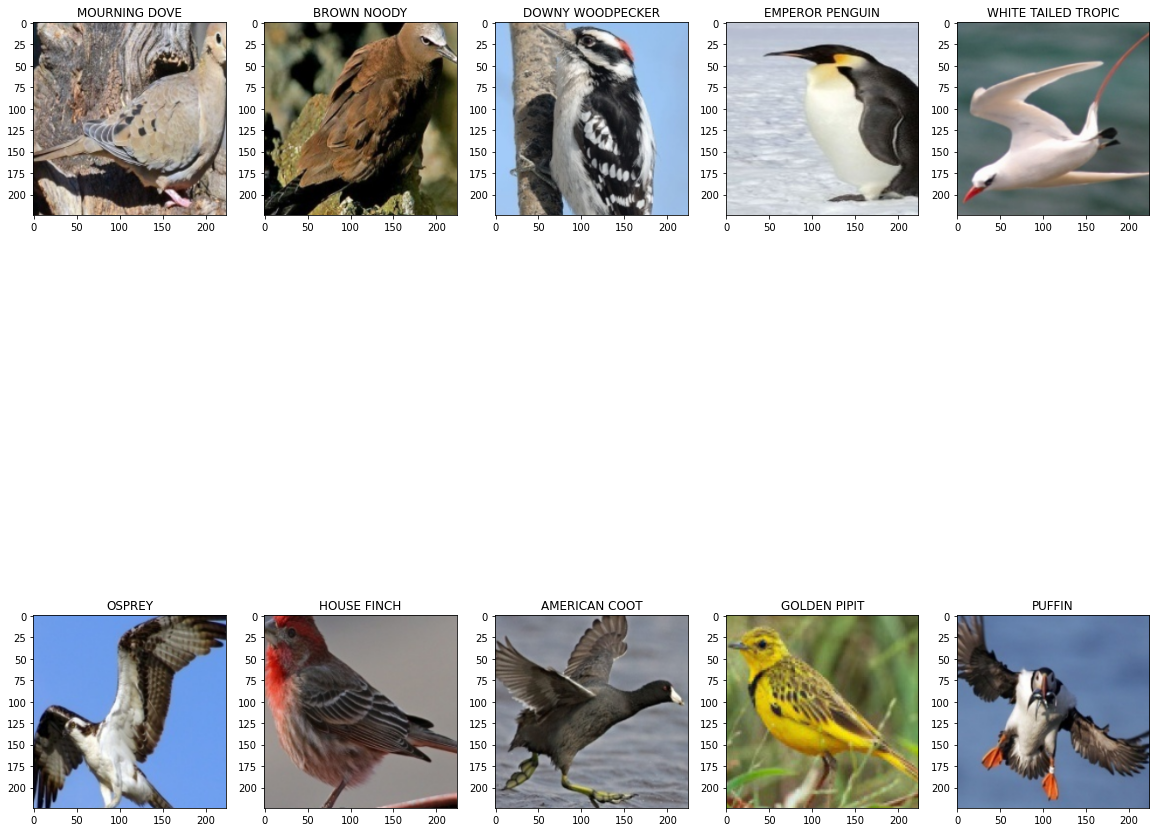

In [10]:
#can comment this and not run because of memory issue 
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    axes[i//cols, i%cols].set_title(name_bird[i])
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [11]:
#dont run
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train (1166, 224, 224, 3)
y_train (1166,)
x_test (291, 224, 224, 3)
y_test (291,)


In [12]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [13]:
batch_size = 32
epochs = 5

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
36/36 [==============================] - 1565s 44s/step - loss: 0.4510 - accuracy: 0.1232 - val_loss: 0.3300 - val_accuracy: 0.1168
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
Epoch 2/5
36/36 [==============================] - 1582s 44s/step - loss: 0.3210 - accuracy: 0.1799 - val_loss: 0.3225 - val_accuracy: 0.1478
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
Epoch 3/5
36/36 [==============================] - 1567s 44s/step - loss: 0.3120 - accuracy: 0.2049 - val_loss: 0.3168 - val_accuracy: 0.1684
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
Epoch 4/5
36/36 [==============================] - 1574s 44s/step - loss: 0.3100 - accuracy: 0.2284 - val_loss: 0.3124 - val_accuracy: 0.2131
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
Epoch 5/5
36/36 [==============================] - 1584s 44s/step - loss: 0.3051 - accuracy: 0.2492 - val_loss: 0.3076 - val_accuracy: 0.2371
INFO:t

CNN: Epochs=5, Train accuracy=0.25838, Validation accuracy=0.23711


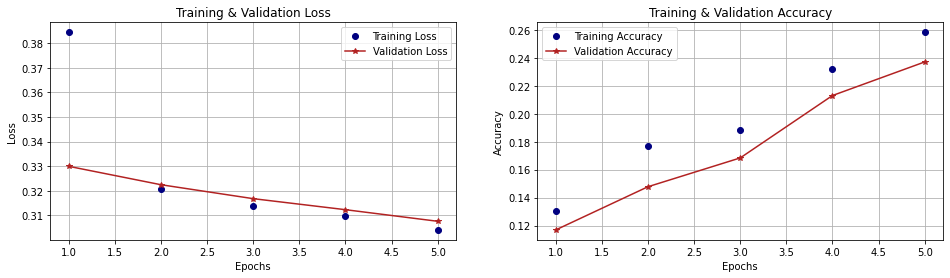

In [14]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

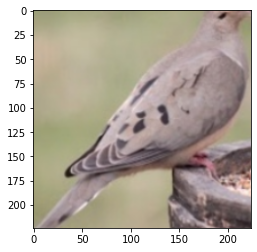

Actual  : MOURNING DOVE
Predict : GOLDEN PIPIT


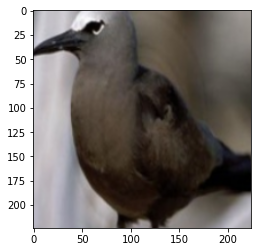

Actual  : BROWN NOODY
Predict : GOLDEN PIPIT


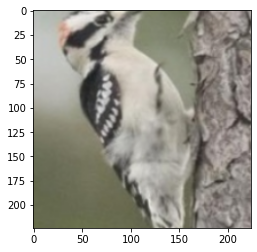

Actual  : DOWNY WOODPECKER
Predict : BROWN NOODY


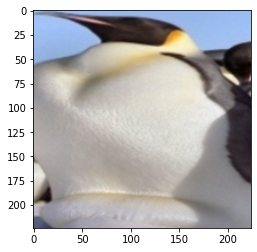

Actual  : EMPEROR PENGUIN
Predict : BROWN NOODY


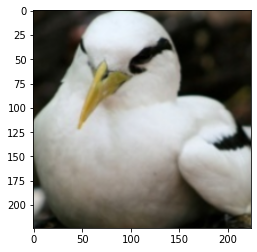

Actual  : WHITE TAILED TROPIC
Predict : WHITE TAILED TROPIC


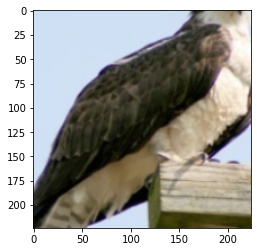

Actual  : OSPREY
Predict : PUFFIN


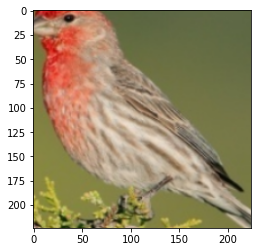

Actual  : HOUSE FINCH
Predict : GOLDEN PIPIT


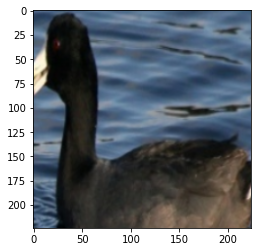

Actual  : AMERICAN COOT
Predict : PUFFIN


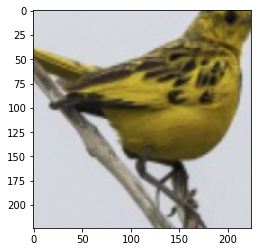

Actual  : GOLDEN PIPIT
Predict : OSPREY


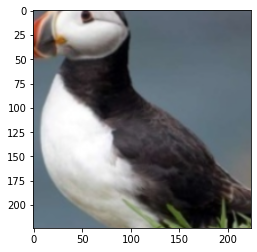

Actual  : PUFFIN
Predict : GOLDEN PIPIT


In [15]:
test_images =[]
j = 40 
for i in range(10):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
prediction = model.predict(test_images)
animals = name_bird
i = 0
for pred in prediction:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1

In [16]:
model.save("Bird_Classification_VGG16.h5")